In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import openmc
import os

In [16]:
# Functions for calculating error

def reformat(arr, dev):
    arr = np.rot90(arr, 3)
    dev = np.rot90(dev, 3)
    val = arr.sum()
    factor = ((17 * 17 * 4) - (25 * 4)) / val
    arr = arr * factor
    dev = dev * factor
    return arr[0:34,0:34], dev[0:34,0:34]

def get_err(fname):
    # Load the statepoint file
    sp = openmc.StatePoint(fname)
    tally = sp.get_tally(scores=['fission'])
    fission = tally.get_slice(scores=['fission'])
    TIME = sp.runtime["simulation"]

    dim = 51
    fission.std_dev.shape = (dim, dim)
    fission.mean.shape = (dim, dim)

    trrm_power, trrm_std_dev = reformat(fission.mean, fission.std_dev)

    ref = np.loadtxt("reference.txt")
    ref = ref.reshape((34, 34))
    val = ref.sum()
    factor = ((17 * 17 * 4) - (25 * 4)) / val
    ref = ref * factor

    trrm_power[trrm_power == 0] = np.nan
    ref[ref == 0] = np.nan

    rel_diff = (trrm_power - ref) / ref

    rel_diff_squared = np.power(rel_diff, 2)

    RMS = math.sqrt(np.nanmean(rel_diff_squared))

    abs_percent_diff = np.absolute(rel_diff)

    RMS = 100.0 * RMS
    AAPE = 100.0 * np.nanmean(abs_percent_diff)
    MAX = 100.0 *np.nanmax(abs_percent_diff)

    return RMS, AAPE, MAX, TIME


In [17]:
# Import Data
N_sim = 20
sim_num = np.arange(1,N_sim+1, dtype=int)
N_particles = np.array([1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 4000])
# N_particles = np.array([1500])

RMS_halton = np.zeros((len(N_particles), N_sim))
AAPE_halton = np.zeros_like(RMS_halton)
MAX_halton = np.zeros_like(RMS_halton)
TIME_halton = np.zeros_like(RMS_halton)

RMS_random = np.zeros_like(RMS_halton)
AAPE_random = np.zeros_like(RMS_halton)
MAX_random = np.zeros_like(RMS_halton)
TIME_random = np.zeros_like(RMS_halton)

file_location = f"{os.getcwd()}/results/N_threads_256/fine_mesh/"
# file_location = f"{os.getcwd()}/results/N_threads_1/"

for i in range(len(N_particles)):
    for j in sim_num:
        fname_halton = file_location+f"N_particles_{N_particles[i]}/halton_rays/sim_{j}.h5"
        fname_random = file_location+f"N_particles_{N_particles[i]}/random_rays/sim_{j}.h5"
        RMS_halton[i, j-1], AAPE_halton[i, j-1], MAX_halton[i, j-1], TIME_halton[i, j-1] = get_err(fname_halton)
        RMS_random[i, j-1], AAPE_random[i, j-1], MAX_random[i, j-1], TIME_random[i, j-1] = get_err(fname_random)

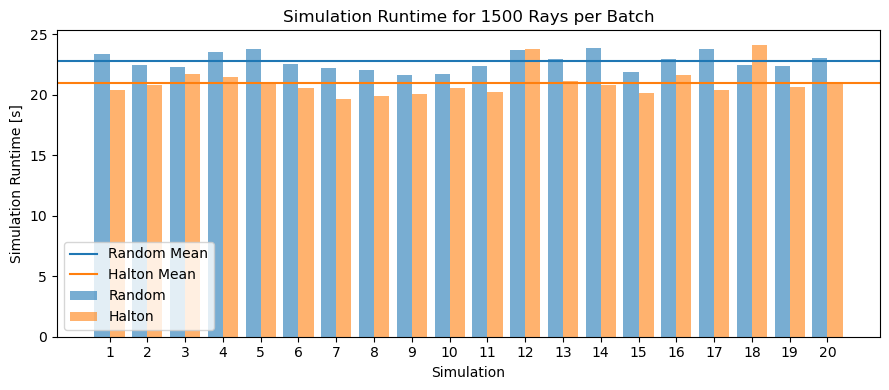

In [18]:
index = 0

plt.figure(figsize=(9,4))
plt.bar(sim_num-0.2, TIME_random[index,:], width=0.4, label='Random', alpha=0.6)
plt.bar(sim_num+0.2, TIME_halton[index,:], width=0.4, label='Halton', alpha=0.6)
x_low, x_high = plt.xlim()
plt.plot([x_low,x_high], [TIME_random[index,:].mean(), TIME_random[index,:].mean()], label='Random Mean')
plt.plot([x_low,x_high], [TIME_halton[index,:].mean(), TIME_halton[index,:].mean()], label='Halton Mean')
plt.xlim(x_low, x_high)
plt.ylabel('Simulation Runtime [s]')
plt.xlabel('Simulation')
plt.title(f'Simulation Runtime for {N_particles[index]} Rays per Batch')
plt.xticks(sim_num)
plt.tight_layout()
plt.legend()


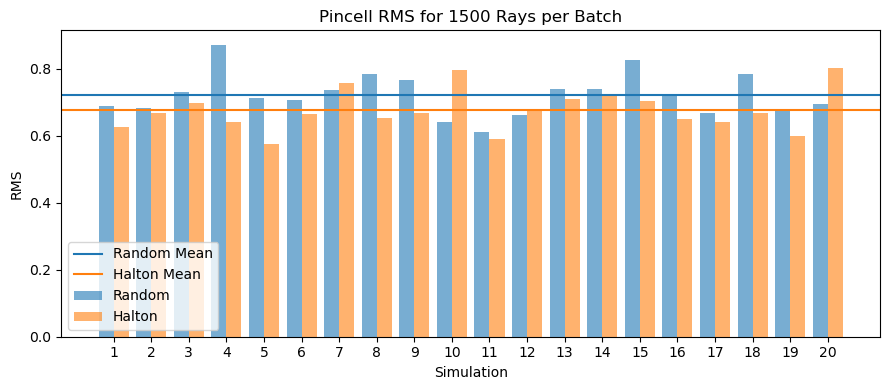

In [19]:
plt.figure(figsize=(9,4))
plt.bar(sim_num-0.2, RMS_random[index,:], width=0.4, label='Random', alpha=0.6)
plt.bar(sim_num+0.2, RMS_halton[index,:], width=0.4, label='Halton', alpha=0.6)
x_low, x_high = plt.xlim()
plt.plot([x_low,x_high], [RMS_random[index,:].mean(), RMS_random[index,:].mean()], label='Random Mean')
plt.plot([x_low,x_high], [RMS_halton[index,:].mean(), RMS_halton[index,:].mean()], label='Halton Mean')
plt.xlim(x_low, x_high)
plt.ylabel('RMS')
plt.xlabel('Simulation')
plt.title(f'Pincell RMS for {N_particles[index]} Rays per Batch')
plt.xticks(sim_num)
plt.tight_layout()
plt.legend()

In [20]:
print(f"Halton Ray Total Simulation Time {TIME_halton.mean().round(2)} pm {TIME_halton.std().round(2)}")
print(f"Random Ray Total Simulation Time {TIME_random.mean().round(2)} pm {TIME_random.std().round(2)}")


Halton Ray Total Simulation Time 30.46 pm 6.47
Random Ray Total Simulation Time 33.84 pm 7.34


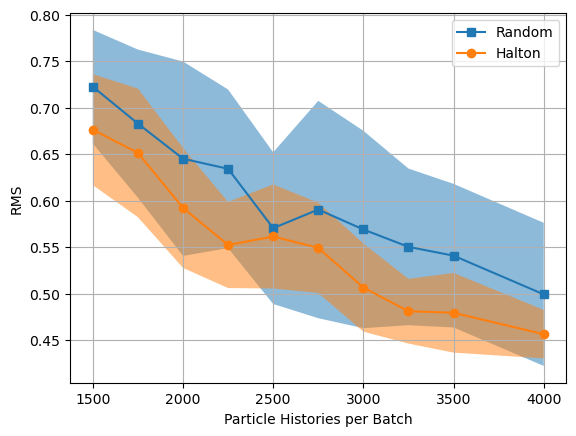

In [21]:
plt.figure()

plt.plot(N_particles, RMS_random.mean(axis=1), '-s', label='Random')
plt.fill_between(N_particles, 
                 RMS_random.mean(axis=1)+RMS_random.std(axis=1),
                 RMS_random.mean(axis=1)-RMS_random.std(axis=1),
                 alpha=0.5)


plt.plot(N_particles, RMS_halton.mean(axis=1), '-o',label='Halton')
plt.fill_between(N_particles, 
                 RMS_halton.mean(axis=1)+RMS_halton.std(axis=1),
                 RMS_halton.mean(axis=1)-RMS_halton.std(axis=1),
                 alpha=0.5)

plt.xlabel('Particle Histories per Batch')
plt.ylabel('RMS')
# plt.yscale('log')
plt.legend()
plt.grid()


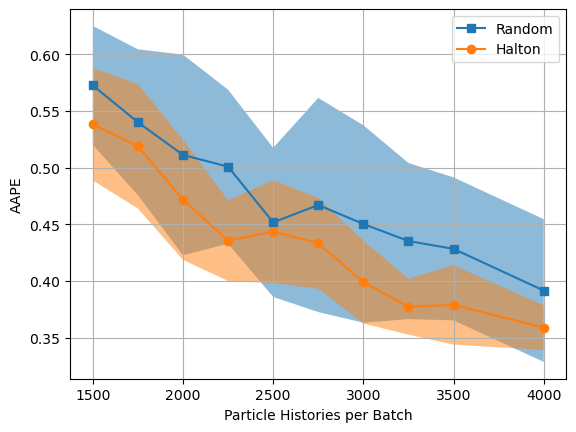

In [22]:
plt.figure()

plt.plot(N_particles, AAPE_random.mean(axis=1), '-s', label='Random')
plt.fill_between(N_particles, 
                 AAPE_random.mean(axis=1)+AAPE_random.std(axis=1),
                 AAPE_random.mean(axis=1)-AAPE_random.std(axis=1),
                 alpha=0.5)


plt.plot(N_particles, AAPE_halton.mean(axis=1), '-o',label='Halton')
plt.fill_between(N_particles, 
                 AAPE_halton.mean(axis=1)+AAPE_halton.std(axis=1),
                 AAPE_halton.mean(axis=1)-AAPE_halton.std(axis=1),
                 alpha=0.5)

plt.xlabel('Particle Histories per Batch')
plt.ylabel('AAPE')
# plt.yscale('log')
plt.legend()
plt.grid()

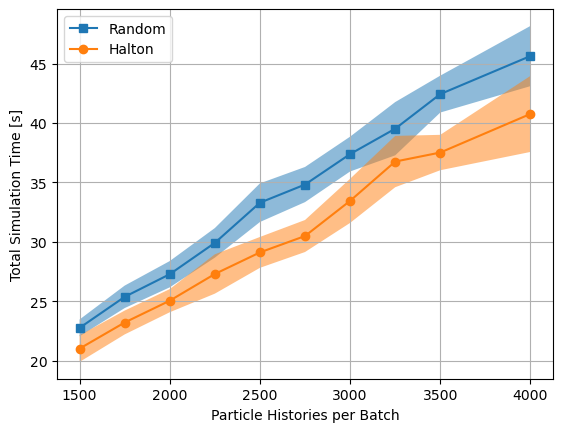

In [23]:
plt.figure()

plt.plot(N_particles, TIME_random.mean(axis=1), '-s', label='Random')
plt.fill_between(N_particles, 
                 TIME_random.mean(axis=1)+TIME_random.std(axis=1),
                 TIME_random.mean(axis=1)-TIME_random.std(axis=1),
                 alpha=0.5)

plt.plot(N_particles, TIME_halton.mean(axis=1), '-o',label='Halton')
plt.fill_between(N_particles, 
                 TIME_halton.mean(axis=1)+TIME_halton.std(axis=1),
                 TIME_halton.mean(axis=1)-TIME_halton.std(axis=1),
                 alpha=0.5)

plt.xlabel('Particle Histories per Batch')
plt.ylabel('Total Simulation Time [s]')
plt.legend()
plt.grid()

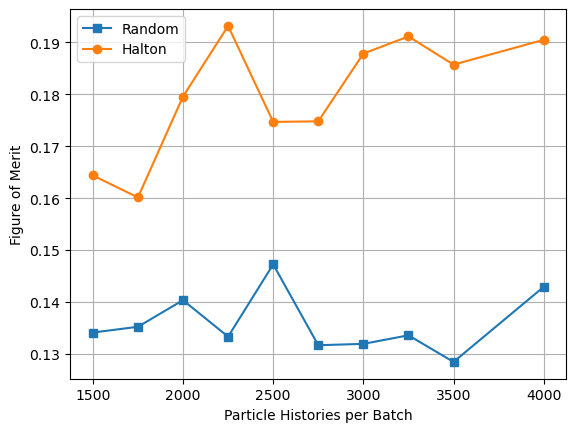

In [24]:
# Figure of Merit

def figure_of_merit(error, time):
    return 1 / (error.mean(axis=1)**2 * time.mean(axis=1))

fom_random = figure_of_merit(AAPE_random, TIME_random)
fom_halton = figure_of_merit(AAPE_halton, TIME_halton)

plt.figure()

plt.plot(N_particles, fom_random, '-s', label='Random')

plt.plot(N_particles, fom_halton, '-o',label='Halton')

plt.xlabel('Particle Histories per Batch')
plt.ylabel('Figure of Merit')
plt.legend()
plt.grid()